# Cookie Cats Mobile Games A/B Testing 

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. This is what the game looks like.

![](https://youtu.be/GaP5f0jVTWE)

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. These gates force the player to take a break, which hopefully increase player enjoyment. 

In this project, I will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40 and how that impact player retention.

Data source: DataCamp.com 

Data columns are: 

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

In [1]:
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

# Explore Data

In [2]:
df = pd.read_csv('datasets/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [12]:
df.describe(include='all')

,userid,version,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189,90189.000000,90189,90189
unique,NaN,2,NaN,2,2
top,NaN,gate_40,NaN,False,False
freq,NaN,45489,NaN,50036,73408
mean,4.998412e+06,NaN,51.872457,NaN,NaN
std,2.883286e+06,NaN,195.050858,NaN,NaN
min,1.160000e+02,NaN,0.000000,NaN,NaN
25%,2.512230e+06,NaN,5.000000,NaN,NaN
50%,4.995815e+06,NaN,16.000000,NaN,NaN
75%,7.496452e+06,NaN,51.000000,NaN,NaN


Check data distribution 

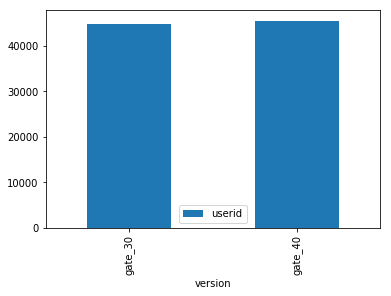

In [14]:
df[['userid','version']].groupby('version').count().plot(kind='bar')

Compare version and game round  

In [3]:
print(df[['sum_gamerounds','version']].groupby('version').mean())

         sum_gamerounds
version                
gate_30       52.456264
gate_40       51.298776


In [8]:
data=df[['sum_gamerounds','version','userid']].groupby(['version','sum_gamerounds'], as_index=False).count()

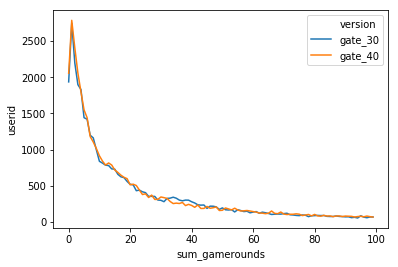

In [20]:
data = data[data['sum_gamerounds']<100]
sns.lineplot(data=data, x="sum_gamerounds",y='userid',hue='version')

Check different between retention_1 and retention_7

         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


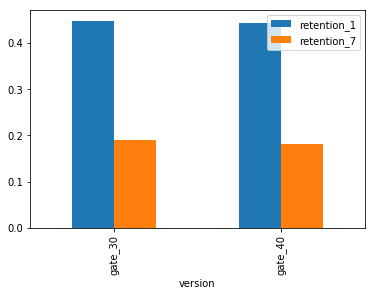

In [21]:
# compare average retention between two gates
print(df[['retention_1','retention_7','version']].groupby('version').mean())
df[['retention_1','retention_7','version']].groupby('version').mean().plot(kind='bar')

Relationship between sum_gamerounds and retention_1 

             sum_gamerounds
retention_1                
False             17.345651
True              94.897467


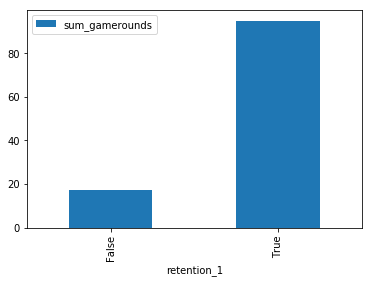

In [24]:
print(df[['retention_1','sum_gamerounds']].groupby('retention_1').mean())
df[['retention_1','sum_gamerounds']].groupby('retention_1').mean().plot(kind='bar')

             sum_gamerounds
retention_7                
False             25.826844
True             165.808236


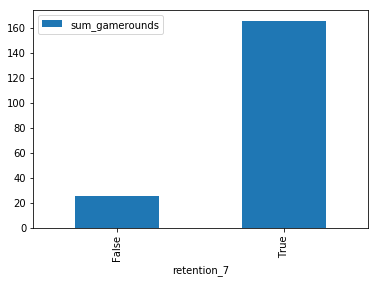

In [25]:
print(df[['retention_7','sum_gamerounds']].groupby('retention_7').mean())
df[['retention_7','sum_gamerounds']].groupby('retention_7').mean().plot(kind='bar')

EPA summary, 
- There are 90189 user data evenly divided between gate_30 and gate_40 experience. 
- Most users play < 20 round for the first 14 days.
- gate_30 have slightly higher retention_1, retention_7, and sum_gamerounds but the differences are small 
- sum_gamegrounds are highly associated with retention.

# 1 Day Retention A/B

1-day retention is % of user that return to play game after installing it for a day, which are about 44.5% with higher retention in the gate_30 group 

In [24]:
print('Overall retention', df['retention_1'].mean())
print('Retention for each group \n', df[['retention_1','version']].groupby('version').mean())

Overall retention 0.4452095044850259
Retention for each group 
          retention_1
version             
gate_30     0.448188
gate_40     0.442283


How can we be certain of the difference? Use bootstrapping technique as follow:

1. Generate a bunch of new datasets by re-sampling the original dataset with replacement. 
2. Calculate the first day retention for each new dataset 
3. Variance of the 1-day retention indicate the uncertainly of the retention 

Note: Bootstrapping is easily done with panda df.sample command 

In [87]:
# numer of bootstrap sample 
iterations = 500 
# empty list to store retention result
boot_1d = []

# generate a bootstrap sample 
for i in range(iterations): 
    sample = df.sample(frac=1,replace=True).groupby('version').mean()
    #append a series into a list
    boot_1d.append(sample['retention_1'])

# conver a list of series into dataframe 
boot_1d = pd.DataFrame(boot_1d)   

In [88]:
boot_1d.head()

version,gate_30,gate_40
retention_1,0.445447,0.444274
retention_1,0.450847,0.444791
retention_1,0.447577,0.440877
retention_1,0.445634,0.440610
retention_1,0.447618,0.449750


In [99]:
boot_1d.describe()

version,gate_30,gate_40
count,500.000000,500.000000
mean,0.448176,0.442440
std,0.002366,0.002326
min,0.439350,0.435720
25%,0.446663,0.440989
50%,0.448182,0.442419
75%,0.449699,0.443992
max,0.455630,0.449750


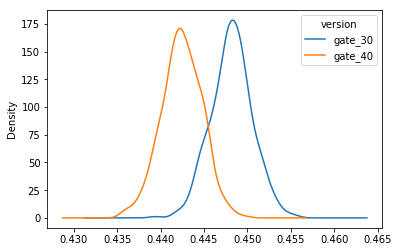

In [89]:
boot_1d.plot.kde()

Bootstrapping result show uncertainly of each dataset. It looks like there are difference between the two version. Next, I will qualify the difference. 

Turn the procedure above into a function 

In [104]:
def boot_AB(df, col, iterations=500):
    ''' input: dataframe to bootstrap, col containing the test data
    and iterations time 
    return: boot_df containing mean of each bootstrap for each A/B experiment
    '''
    boot_1d = []
    # generate a bootstrap sample
    for i in range(iterations):
        sample = df.sample(frac=1,replace=True).groupby('version').mean()
        #append a series into a list
        boot_1d.append(sample[col])
        
    # conver a list of series into dataframe 
    return pd.DataFrame(boot_1d)   

In [105]:
#test the function 
boot_1d = boot_AB(df,'retention_1',10000)

In [106]:
boot_1d.head()

version,gate_30,gate_40
retention_1,0.446828,0.441513
retention_1,0.450904,0.441361
retention_1,0.449942,0.444891
retention_1,0.442132,0.442676
retention_1,0.447317,0.444356


## Probability of the difference 

In [107]:
# calculate the percent difference between two gates for each bootstrap 
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100

Text(0.5, 0, 'percent difference')

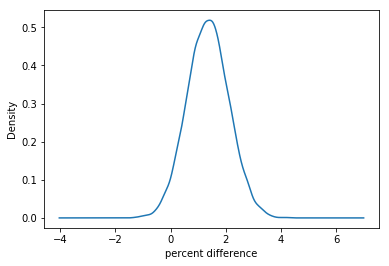

In [109]:
# Ploting the bootstrap % difference
boot_1d['diff'].plot.kde()
plt.xlabel('percent difference')

In [111]:
print('average difference is ', boot_1d['diff'].mean() )
print('probabiliy that the difference is larger than zero is ', (boot_1d['diff']>0.0).mean())

average difference is  1.3549344644294796
probabiliy that the difference is larger than zero is  0.966


# 7 Day Retention A/B

Similar analysis can be carried out with the retention_7 column. Here, we get

In [112]:
boot_7d = boot_AB(df,'retention_7',10000)

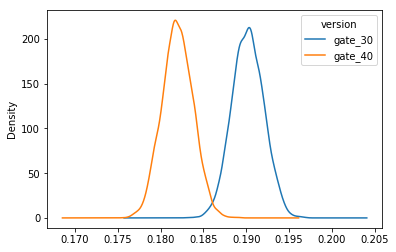

In [113]:
boot_7d.plot.kde()

In [114]:
def AB_diff(boot):
    
    # calculate the percent difference between two gates for each bootstrap 
    boot['diff'] = (boot['gate_30']-boot['gate_40'])/boot['gate_40']*100
    
    print('average difference is ', boot['diff'].mean() )
    print('probabiliy that the difference is larger than zero is ', (boot['diff']>0.0).mean())
    
    boot['diff'].plot.kde()
    plt.xlabel('percent difference')

average difference is  4.524428641661296
probabiliy that the difference is larger than zero is  0.9986


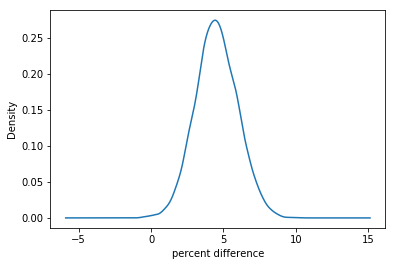

In [115]:
AB_diff(boot_7d)

The difference between two AB-groups is larger for the 7-day retention.

# Conclusion 

User retention increase in the group facing gate at level 30, which is an earlier level. Larger difference is seen in the 7-day retention data.  This result suggests that forcing players to take a break prolong their engagement. 